In [59]:
# imports and basic notebook setup
from cStringIO import StringIO
import numpy as np
import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from google.protobuf import text_format
import caffe
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
model_path = '/p/lscratche/brainusr/networks/bvlc_googlenet' # substitute your path here
net_fn   = os.path.join(model_path,'deploy.prototxt')
param_fn = os.path.join(model_path,'bvlc_googlenet.caffemodel')

# Patching model to be able to compute gradients.
# Note that you can also manually add "force_backward: true" line to "deploy.prototxt".
model = caffe.io.caffe_pb2.NetParameter()
text_format.Merge(open(net_fn).read(), model)
model.force_backward = True
open('tmp.prototxt', 'w').write(str(model))

In [14]:
net = caffe.Classifier('tmp.prototxt', param_fn,
                       mean = np.float32([104.0, 116.0, 122.0]), # ImageNet mean, training set dependent
                       channel_swap = (2,1,0)) # the reference model has channels in BGR order instead of RGB

# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']
def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

In [26]:
a = net.transformer.mean['data']


In [27]:
print a

[[[ 104.]]

 [[ 116.]]

 [[ 122.]]]


In [28]:
b = net.blobs['data']


In [29]:
b.data.shape


(10, 3, 224, 224)

In [30]:
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
#transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

net.blobs['data'].reshape(10, 3, 224, 224)

In [31]:
net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image('/usr/gapps/brain/tools/deepdream/sky1024px.jpg'))


In [108]:
net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image('/g/g14/widemann/python_caffe_notebooks/caffe/examples/images/cat.jpg'))


In [109]:
out = net.forward()
print("Predicted class is #{}.".format(out['prob'].argmax()))

Predicted class is #282.


In [110]:
out['prob'].shape

(10, 1000)

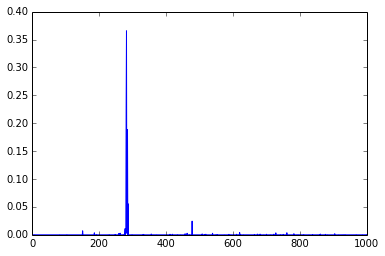

In [111]:
tmp = out['prob'][0]
plt.plot(tmp)

In [83]:
A = caffe.io.load_image('/g/g14/widemann/python_caffe_notebooks/caffe/examples/images/cat.jpg')
A.shape

(360, 480, 3)

In [54]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

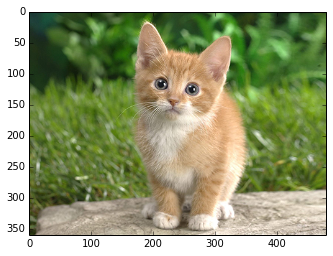

In [62]:
plt.imshow(A)

In [63]:
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (10, 3, 224, 224)),
 ('conv1/7x7_s2', (10, 64, 112, 112)),
 ('pool1/3x3_s2', (10, 64, 56, 56)),
 ('pool1/norm1', (10, 64, 56, 56)),
 ('conv2/3x3_reduce', (10, 64, 56, 56)),
 ('conv2/3x3', (10, 192, 56, 56)),
 ('conv2/norm2', (10, 192, 56, 56)),
 ('pool2/3x3_s2', (10, 192, 28, 28)),
 ('pool2/3x3_s2_pool2/3x3_s2_0_split_0', (10, 192, 28, 28)),
 ('pool2/3x3_s2_pool2/3x3_s2_0_split_1', (10, 192, 28, 28)),
 ('pool2/3x3_s2_pool2/3x3_s2_0_split_2', (10, 192, 28, 28)),
 ('pool2/3x3_s2_pool2/3x3_s2_0_split_3', (10, 192, 28, 28)),
 ('inception_3a/1x1', (10, 64, 28, 28)),
 ('inception_3a/3x3_reduce', (10, 96, 28, 28)),
 ('inception_3a/3x3', (10, 128, 28, 28)),
 ('inception_3a/5x5_reduce', (10, 16, 28, 28)),
 ('inception_3a/5x5', (10, 32, 28, 28)),
 ('inception_3a/pool', (10, 192, 28, 28)),
 ('inception_3a/pool_proj', (10, 32, 28, 28)),
 ('inception_3a/output', (10, 256, 28, 28)),
 ('inception_3a/output_inception_3a/output_0_split_0', (10, 256, 28, 28)),
 ('inception_3a/output_inception_

In [112]:
outL = net.forward(end='pool5/7x7_s1')

In [113]:
outL['pool5/7x7_s1'].shape

(10, 1024, 1, 1)

In [114]:
A = np.squeeze(outL['pool5/7x7_s1'])

In [116]:
A.shape

(10, 1024)

In [118]:
A

array([[ 1.37596571,  0.11012316,  0.87542403, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.37596571,  0.11012316,  0.87542403, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.37596571,  0.11012316,  0.87542403, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 1.37596571,  0.11012316,  0.87542403, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.37596571,  0.11012316,  0.87542403, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.37596571,  0.11012316,  0.87542403, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [121]:
tmp = caffe.io.load_image('/g/g14/widemann/python_caffe_notebooks/caffe/examples/images/cat.jpg')
net.blobs['data'].data[0] = transformer.preprocess('data',tmp)
net.blobs['data'].data[1] = transformer.preprocess('data',np.zeros(tmp.shape))

In [125]:
B = net.forward(end='pool5/7x7_s1')


IndexError: too many indices for array

In [130]:
C = np.squeeze(B['pool5/7x7_s1'])
C.shape
C[:,0:4]

array([[ 1.37596571,  0.11012316,  0.87542403,  0.08062635],
       [ 0.26956117,  0.        ,  0.00448309,  0.        ],
       [ 1.37596571,  0.11012316,  0.87542403,  0.08062635],
       [ 1.37596571,  0.11012316,  0.87542403,  0.08062635],
       [ 1.37596571,  0.11012316,  0.87542403,  0.08062635],
       [ 1.37596571,  0.11012316,  0.87542403,  0.08062635],
       [ 1.37596571,  0.11012316,  0.87542403,  0.08062635],
       [ 1.37596571,  0.11012316,  0.87542403,  0.08062635],
       [ 1.37596571,  0.11012316,  0.87542403,  0.08062635],
       [ 1.37596571,  0.11012316,  0.87542403,  0.08062635]], dtype=float32)

In [131]:
import os
import sys
cocoLib ='/p/lscratche/brainusr/datasets/coco-master/PythonAPI'
sys.path.append(cocoLib)
from pycocotools.coco import COCO
#from colorama import Fore

In [132]:
maxCaptionLength = 50
imageWidth = 227
imageHeight = 227
dataDir='/p/lscratche/brainusr/datasets/coco-master'
dataType='val2014' 
createMeanSample = True #True
instanceFile='%s/annotations/instances_%s.json'%(dataDir,dataType)
annFile = '%s/annotations/captions_%s.json'%(dataDir,dataType)
writeToDirec = '/p/lscratchd/widemann/coco'
catNms = ['person','dogs']
numCaptionsToUse = 1 # every image should have at least 5 captions 
mxint8 = 255. # use this to map the pixel values in [0,1]
numChannels = 3
doLower = True # make all words lowercase
maxOneFile = 100
maxSamples = 10 #np.inf
outfile = 'train'
comp_kwargs = {'compression': 'gzip', 'compression_opts': 1}

In [133]:
coco=COCO(instanceFile)
catIds = coco.getCatIds(catNms=catNms)
imgIds = coco.getImgIds(catIds=catIds)
imgs = coco.loadImgs(imgIds)
if maxSamples < len(imgs):
    imgs = map(lambda x: imgs[x], np.random.permutation(len(imgs))[0:maxSamples])
meanSample = np.zeros((numChannels,imageWidth,imageHeight))
caps=COCO(annFile)
numImgs = len(imgs)
numSamples = numImgs*numCaptionsToUse
fileInds = range(0,numSamples,maxOneFile)


loading annotations into memory...
0:00:09.012228
creating index...
index created!
loading annotations into memory...
0:00:00.980682
creating index...
index created!


In [147]:
annIds = caps.getAnnIds(imgIds=imgs[0]['id'])

In [151]:
ann = caps.loadAnns(annIds)
ann

[{u'caption': u'The cross country skier is working very hard.',
  u'id': 747606,
  u'image_id': 540207},
 {u'caption': u'The skier wearing a racing number is ascending a snowy slope. ',
  u'id': 748095,
  u'image_id': 540207},
 {u'caption': u'this is a woman riding her skis in the snow',
  u'id': 750644,
  u'image_id': 540207},
 {u'caption': u'A person wearing skis standing in the snow.',
  u'id': 756693,
  u'image_id': 540207},
 {u'caption': u'a person riding skis on a snowy surface ',
  u'id': 759493,
  u'image_id': 540207}]

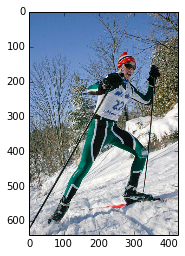

In [150]:
I = caffe.io.load_image('%s/images/%s/%s'%(dataDir,dataType,imgs[0]['file_name']))
plt.imshow(I)